# Classifying the type of flooring surface using data collected by Inertial Measurement Units sensors

Author: Patrick Alves (cpatrickalves@gmail.com)
Date: 09/23/2019

Data source: Tampere University Signal Processing Department in Finland.

Competition page: https://www.kaggle.com/c/competicao-dsa-machine-learning-sep-2019/

## Exploratory Data Analysis

The sensor data collected includes accelerometer data, gyroscope data (angular
rate) and internally estimated orientation. Specifically:

* Orientation: 4 attitude quaternion (a mathematical notation used to represent orientations and rotations in a 3D space) channels, 3 for vector part and one for scalar part;
* Angular rate: 3 channels, corresponding to the 3 IMU coordinate axes X, Y, and Z;
* Acceleration: 3 channels, specific force corresponding to 3 IMU coordinate axes X, Y, and Z.

Each data point includes the measures described above of orientation, velocity and acceleration, resulting in a feature vector of length 10 for each point.

There are 128 measurements per time series plus three identification columns:
* ***row_id***: The ID for the row.
* ***series_id***: a number that identify the measurement series. It is also the foreign key to **y_train** and sample_submission.
* ***measurement_number***: measurement number within the series.


#### Loading the data

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
X_train = pd.read_csv("data/X_treino.csv")
y_train = pd.read_csv("data/y_treino.csv")
X_test = pd.read_csv("data/X_teste.csv")

In [4]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [5]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


Number of  time series: 3810
Surfaces frequency distribution:
concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64


Text(0, 0.5, 'Number of time series')

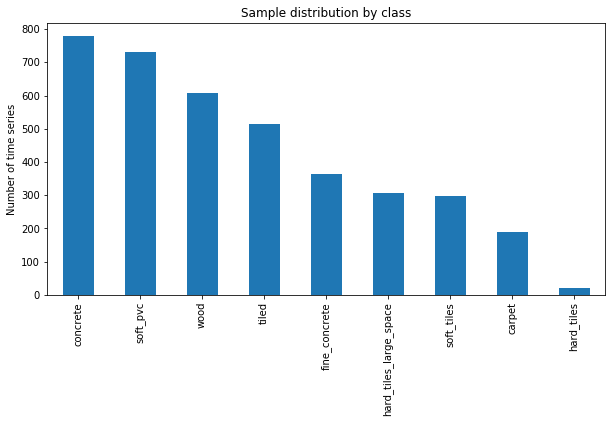

In [27]:
# Check unique values
count_series = len(X_train.series_id.unique())
freq_distribution_surfaces = y_train.surface.value_counts()

print(f"Number of  time series: {count_series}")
print(f"Surfaces frequency distribution:\n{freq_distribution_surfaces}")
freq_distribution_surfaces.plot(kind="bar", figsize=(10,5))
plt.title("Sample distribution by class")
plt.ylabel("Number of time series")

So, the train data set contains 3800 labeled time series samples, with the corresponding surface type annotation. 

Most of the samples are for the concrete surface. The *hard_tiles* has only 21 samples, this may be insufficient to build a robust model for this type of surface.

## References
* https://www.researchgate.net/publication/332799607_Surface_Type_Classification_for_Autonomous_Robot_Indoor_Navigation
* https://tutcris.tut.fi/portal/files/5080646/Collin14_VT_post_print.pdf
* https://ieeexplore.ieee.org/author/38294930400
* https://www.kaggle.com/c/career-con-2019/overview
* https://www.kaggle.com/c/robotsurface